In [1]:
import math, operator, torch
import matplotlib.pyplot as plt
from functools import partial

from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

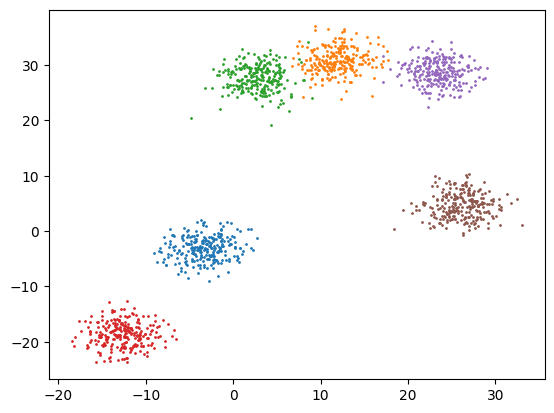

In [16]:
# Clustering analysis is best used when you have points that are for the same kind of scale.
n_clusters = 6
n_samples = 250

# Creating torch.rand(number of clusters, 2) so that we get an x and y value
centroids = (torch.rand(n_clusters, 2) * 70) - 35

# After we have created 6 centroids then we can use a multivariate normal to sample normal distributions around the centroids
def sample(m): 
    # It will give us random colummns of data with thatstandard deviation
    return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: 
        _,ax = plt.subplots()
    for i, _ in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)

plot_data(centroids, data, n_samples)

In [ ]:
# Mean shift clustering does not require selecting the number o fclusters in advnace just a bandwidth that we specify, it can however be chosen automatically.
# Mean shift can also handle clusters of any shape 

# For each point we get a weighted average based on the weighted distance from taht point and every other point.
# Creating weights using a gaussian kernel of htat points distnace - this weighting penalises points that are further from x
# The bandwidth heree is teh standard deviation of the gaussian and thus determines the rate at which teh weights fall to 0.

tensor([ 9.222, 11.604])

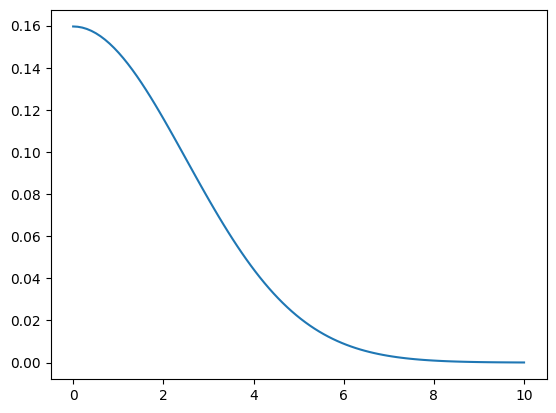

In [17]:
# This is the gaussian equation that will define our bandwidth
# Typically in mean shift clustering a bandwidth that will cover around a third of the data is a good idea
# If you dont want to use gaussians then you can always use a triangular weighting too
def gaussian(d, bw): 
    return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

# partial in functools is currying - it will create a new function that is partially applied adn hence it will partially apply teh bandwidth to the gaussian function which can then be used
plot_func(partial(gaussian, bw=2.5))

In [18]:
X = data.clone()
x = data[0]

In [ ]:
# We can get the differernce between them and after we sum, get the square root
dist = ((x-X)**2).sum(1).sqrt()
dist[:8]

weight = gaussian(dist, 2.5)

# Mean shift clustering we get the weighted mean between points
# This will change teh value of X variable and will do the update
# The update will take teh weights multiplied by
def one_update(X):
    for i, x in enumerate(X):
        # calculate the distance from the point to all other points
        dist = torch.sqrt(((x-X)**2).sum(1))
        # Get the weight based on teh distance
        weight = gaussian(dist, 2.5)
        # Update teh place based on its weights
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

def meanshift(data):
    # We have to make sure that we can clone the data as this will update the actual values
    X = data.clone()
    for _ in range(5): 
        one_update(X)
    return X

plot_data(centroids + 2, X, n_samples)

tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002])

In [22]:
# If we create a batch size of 5 then we can do 5 at a time on the data
bs = 5
X = data.clone()
x = X[:bs]
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [25]:
# This distance calculation will broadcast the a vector minus the b vector then square all those values and sum them up - finally square rooting
def dist_b(a,b): 
    return (((a[None]-b[:,None])**2).sum(2)).sqrt()

dist_b(X, x), dist_b(X, x).shape

X[None,:].shape, x[:,None].shape, (X[None,:]-x[:,None]).shape

(tensor([[ 0.000,  3.786,  5.292,  ..., 35.409, 31.611, 27.246],
         [ 3.786,  0.000,  7.796,  ..., 34.882, 31.081, 26.609],
         [ 5.292,  7.796,  0.000,  ..., 31.438, 27.690, 23.513],
         [ 8.466,  6.013,  9.042,  ..., 29.432, 25.661, 21.157],
         [ 3.463,  5.173,  2.681,  ..., 32.029, 28.238, 23.910]]),
 torch.Size([5, 1500]))

In [27]:
# If we use a gaussian then the gaussian is a scalar value that can be broadcast over anything
# Our gaussian function will take t
weight = gaussian(dist_b(X, x), 2)
weight

tensor([[    0.199,     0.033,     0.006,  ...,     0.000,     0.000,     0.000],
        [    0.033,     0.199,     0.000,  ...,     0.000,     0.000,     0.000],
        [    0.006,     0.000,     0.199,  ...,     0.000,     0.000,     0.000],
        [    0.000,     0.002,     0.000,  ...,     0.000,     0.000,     0.000],
        [    0.045,     0.007,     0.081,  ...,     0.000,     0.000,     0.000]])

In [31]:
num = (weight[...,None]*X[None]).sum(1)
num.shape, num

# This gives the exactly the same result
torch.einsum('ij,jk->ik', weight, X)

# So does this
weight @ X

tensor([[-58.082, -55.979],
        [-63.547, -31.591],
        [ -8.513, -23.451],
        [ -7.416,  -2.407],
        [-39.873, -64.462]])

In [33]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for _ in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div
    return X

In [34]:
data = data.cuda()
X = meanshift(data).cpu()
X

AssertionError: Torch not compiled with CUDA enabled